In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# entropy = - sum (p log2 p)
# p = unique elements / all elements -> uniform distribution

def entropy(X):
    vals,counts = np.unique(X, return_counts=True,axis=0)
    probs = counts / len(X)
    return - np.sum(probs * np.log2(probs))

# I(X,Y) = H(X) + H(Y) - H(X,Y)

def MI(X,Y):
    HX = entropy(X)
    HY = entropy(Y)
    HXY = entropy(np.column_stack((X,Y)))
    return HX + HY - HXY

In [4]:
# generates 2D bit array of N size and probability >=p of X and Y matching

def get_correlated_data(p,N):
    X = np.random.randint(0,2,N) # N ints between 0 and 2
    Y = np.zeros(N) # N zeroes
    for i in range(N):
        if np.random.rand() < p: # make Y[i] match X[i] with p probability
            Y[i] = X[i]
        else: # otherwise set Y[i] to random
            Y[i] = np.random.randint(0,2)
    return X,Y

In [5]:
p_range = np.linspace(0,1,100) # evenly spaced array of 100 values between 0 and 1, inclusive
MI_vals = [MI(*get_correlated_data(p,1000)) for p in p_range] # for random 2D bit arrays of size 1000, calculate their MI

# * like decoupling the return to fill parameters

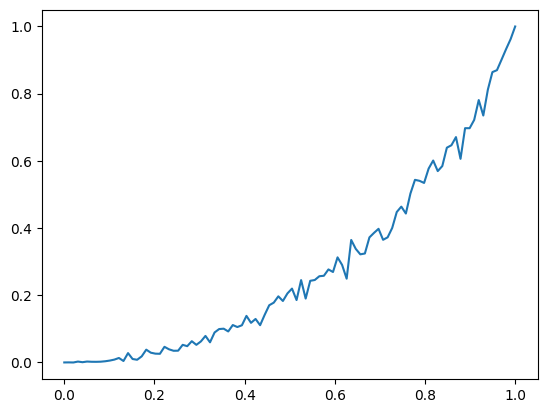

In [6]:
plt.plot(p_range,MI_vals) # as probability of X and Y matching increases, so does their MI

In [7]:
from jpype import *


In [8]:
def start_JVM():
    jarLocation = "infodynamics.jar" # Java library for information processing
    if not isJVMStarted():
        startJVM(getDefaultJVMPath(), "-ea", "-Xmx1024m", "-Djava.class.path=" + jarLocation)

def calc_mi(a, b): # calculate MI using Java library
    start_JVM()
    if(len(np.shape(a))==1):
        a = a.reshape((-1,1))
    if(len(np.shape(b))==1):
        b = b.reshape((-1,1))
    _,d1 = np.shape(a)
    _,d2 = np.shape(b)
    mi_calc = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian()
    mi_calc.initialise(d1,d2)
    mi_calc.setObservations(a.tolist(),b.tolist())
    mi_val = mi_calc.computeAverageLocalOfObservations()
    return mi_val


In [11]:
def gen_normal_data(N,corr): # generate N pairs of normally distributed random variables with the given correlation
    cov = np.array([[1,corr],[corr,1]])
    data = np.random.multivariate_normal([0,0],cov,N)
    return data[:,0],data[:,1]

mi_vals_gauss = [calc_mi(*gen_normal_data(1000,p)) for p in p_range] # for normally distributed 2D arrays of size 1000, calculate their MI

infodynamics.utils.NonPositiveDefiniteMatrixException: infodynamics.utils.NonPositiveDefiniteMatrixException: CholeskyDecomposition is only performed on positive-definite matrices. Some reasons for non-positive-definite matrix are listed at http://www2.gsu.edu/~mkteer/npdmatri.html - note: a correlation matrix is non-positive-definite if you have more variables than observations

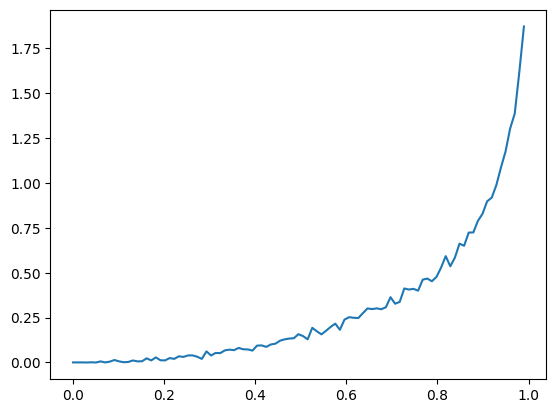

In [ ]:
plt.plot(p_range[:-1],mi_vals_gauss[:-1])

In [12]:
from lz76 import LZ76

# calculate entropy rate for a binary string

def calc_er(X):
    lz = LZ76(X) # Compute Lempel-Ziv complexity
    er = lz*np.log2(len(X))/len(X) # Normalize using log2(length)
    return er

In [13]:
# computes the average entropy rate over non-overlapping windows of a binary sequence X

def get_er_windows(X,window_size):
    er_vals = [] # List to store entropy rates of each window
    for i in range(0,len(X),window_size): # Iterate over X in steps of window_size
        er_vals.append(calc_er(X[i:i+window_size])) # Compute entropy rate for each window
    return np.mean(er_vals) # Return the average entropy rate

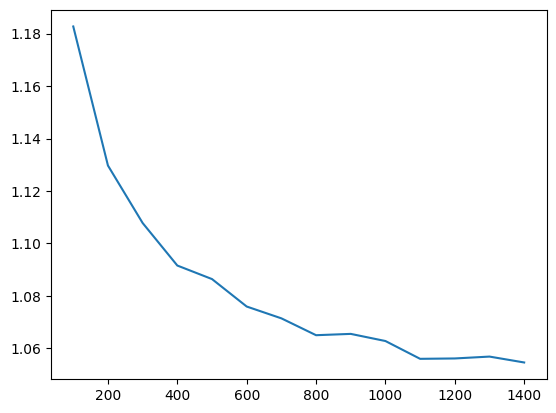

In [14]:
X = np.random.randint(0,2,100000) # Generates a random binary sequence of size 100000
win_sizes = np.arange(100,1500,100) # Define window sizes from 100 to 1400 in steps of 100
er_vals = [get_er_windows(X,win_size) for win_size in win_sizes] # Compute entropy rate for each window size
plt.plot(win_sizes,er_vals) # Plot window size vs. entropy rate

# As the window size increases, the entropy rate stabilizes
# Larger window size > less surprise

# Purely random X should have ER = 1
# Structured sequence's ER would decrease for larger windows

# Linear Dependencies

In [ ]:
import tableprint as tp

In [ ]:
# Generate 10 values per array of N(0, 0.2)

X = np.random.normal(0,0.2,10).tolist()
Y = np.random.normal(0,0.2,10).tolist()
Z = np.random.normal(0,0.2,10).tolist()

# Coupled stochastic time series with autoregressive and cross-variable dependencies

for i in range(10000):
    X.append(0.5*X[-1] + 0.2*Y[-4] + np.random.normal(0,0.1))
    Y.append(-0.5*Y[-3] + 0.1*Z[-2] + np.random.normal(0,0.1))
    Z.append(0.6*X[-5] + np.random.normal(0,0.1))

In [ ]:
JX = JArray(JDouble, 1)(X)
JY = JArray(JDouble, 1)(Y)
JZ = JArray(JDouble, 1)(Z)

def calc_te_gaussian(src, dest, delay):
    calcClass = JPackage("infodynamics.measures.continuous.gaussian").TransferEntropyCalculatorGaussian
    calc = calcClass()
    calc.setProperty("DELAY", str(delay))
    calc.initialise()
    calc.setObservations(src, dest)
    result = calc.computeAverageLocalOfObservations()
    return result

def calc_te_kraskov(src, dest, delay):
    calcClass = JPackage("infodynamics.measures.continuous.kraskov").TransferEntropyCalculatorKraskov
    calc = calcClass()
    calc.setProperty("DELAY", str(delay))
    calc.initialise()
    calc.setObservations(src, dest)
    result = calc.computeAverageLocalOfObservations()
    return result

def calc_te_cond_gaussian(src, dest, cond, delay, cond_delay):
    calcClass = JPackage("infodynamics.measures.continuous.gaussian").ConditionalTransferEntropyCalculatorkraskov
    calc = calcClass()
    calc.setProperty("DELAY", str(delay))
    calc.setProperty("COND_DELAYS", str(cond_delay))
    calc.initialise()
    calc.setObservations(src, dest, cond)
    result = calc.computeAverageLocalOfObservations()
    return result

def calc_te_cond_kraskov(src, dest, cond, delay, cond_delay):
    calcClass = JPackage("infodynamics.measures.continuous.kraskov").ConditionalTransferEntropyCalculatorKraskov
    calc = calcClass()
    calc.setProperty("DELAY", str(delay))
    calc.setProperty("COND_DELAYS", str(cond_delay))
    calc.initialise()
    calc.setObservations(src, dest, cond)
    result = calc.computeAverageLocalOfObservations()
    return result

def format_float(arr):
    return np.array([["{:.5f}".format(val) for val in row] for row in arr])

In [ ]:
XYgaussian = []
ZYgaussian = []
YXgaussian = []
for i in range(9):
    XYgaussian.append(calc_te_gaussian(JX,JY,i+1))
    ZYgaussian.append(calc_te_gaussian(JZ,JY,i+1))
    YXgaussian.append(calc_te_gaussian(JY,JX,i+1))

data = [XYgaussian, ZYgaussian, YXgaussian]
data = format_float(data)

delay_column = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
data = np.insert(data, 0, delay_column, axis=0)

headers = ['Delay', 'X > Y', 'Z > Y', 'Y > X']

tp.banner('Transfer Entropy (Gaussian)')
tp.table(list(zip(*data)), headers)

╒══════════════════════════════╕
│   Transfer Entropy (Gaussian)│
╘══════════════════════════════╛
╭─────────┬─────────┬─────────┬─────────╮
│   Delay │   X > Y │   Z > Y │   Y > X │
├─────────┼─────────┼─────────┼─────────┤
│       1 │ 0.00147 │ 0.00002 │ 0.00740 │
│       2 │ 0.00136 │ 0.00448 │ 0.00025 │
│       3 │ 0.00002 │ 0.00007 │ 0.00000 │
│       4 │ 0.00060 │ 0.00013 │ 0.02525 │
│       5 │ 0.00059 │ 0.00143 │ 0.00029 │
│       6 │ 0.00000 │ 0.00000 │ 0.00001 │
│       7 │ 0.00002 │ 0.00000 │ 0.00669 │
│       8 │ 0.00005 │ 0.00036 │ 0.00018 │
│       9 │ 0.00002 │ 0.00003 │ 0.00001 │
╰─────────┴─────────┴─────────┴─────────╯


In [ ]:
XYcondZgaussian = []
ZYcondXgaussian = []
YXcondZgaussian = []
for d in range(8):
    tempXYcondZ = []
    tempZYcondX = []
    tempYXcondZ = []
    for cd in range(8):
        tempXYcondZ.append(calc_te_cond_gaussian(JX,JY,JZ,d+1,cd+1))
        tempZYcondX.append(calc_te_cond_gaussian(JZ,JY,JX,d+1,cd+1))
        tempYXcondZ.append(calc_te_cond_gaussian(JY,JX,JZ,d+1,cd+1))
    XYcondZgaussian.append(tempXYcondZ)
    ZYcondXgaussian.append(tempZYcondX)
    YXcondZgaussian.append(tempYXcondZ)

dataXYcondZgaussian = format_float(XYcondZgaussian)
dataZYcondXgaussian = format_float(ZYcondXgaussian)
dataYXcondZgaussian = format_float(YXcondZgaussian)

delay_column = ['1', '2', '3', '4', '5', '6', '7', '8']
dataXYcondZgaussian = np.insert(dataXYcondZgaussian, 0, delay_column, axis=1)
dataZYcondXgaussian = np.insert(dataZYcondXgaussian, 0, delay_column, axis=1)
dataYXcondZgaussian = np.insert(dataYXcondZgaussian, 0, delay_column, axis=1)

headers = ['Delay / Cond', '1', '2', '3', '4', '5', '6', '7', '8']

tp.banner('Conditional Transfer Entropy (Gaussian) (X > Y | Z)')
tp.table(dataXYcondZgaussian, headers)

╒═══════════════════════════════════════════════════╕
│Conditional Transfer Entropy (Gaussian) (X > Y | Z)│
╘═══════════════════════════════════════════════════╛
╭──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────╮
│ Delay / Cond │            1 │            2 │            3 │            4 │            5 │            6 │            7 │            8 │
├──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│            1 │      0.00147 │      0.00151 │      0.00146 │      0.00146 │      0.00143 │      0.00147 │      0.00146 │      0.00145 │
│            2 │      0.00136 │      0.00136 │      0.00136 │      0.00137 │      0.00136 │      0.00137 │      0.00137 │      0.00132 │
│            3 │      0.00002 │      0.00002 │      0.00002 │      0.00002 │      0.00002 │      0.00002 │      0.00002 │      0.00002 │
│            4 │

In [ ]:
tp.banner('Conditional Transfer Entropy (Gaussian) (Z > Y | X)')
tp.table(dataZYcondXgaussian, headers)

╒═══════════════════════════════════════════════════╕
│Conditional Transfer Entropy (Gaussian) (Z > Y | X)│
╘═══════════════════════════════════════════════════╛
╭──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────╮
│ Delay / Cond │            1 │            2 │            3 │            4 │            5 │            6 │            7 │            8 │
├──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│            1 │      0.00002 │      0.00002 │      0.00002 │      0.00002 │      0.00001 │      0.00002 │      0.00002 │      0.00002 │
│            2 │      0.00453 │      0.00448 │      0.00451 │      0.00458 │      0.00457 │      0.00451 │      0.00450 │      0.00450 │
│            3 │      0.00007 │      0.00006 │      0.00007 │      0.00007 │      0.00006 │      0.00007 │      0.00008 │      0.00007 │
│            4 │

In [ ]:
tp.banner('Conditional Transfer Entropy (Gaussian) (Y > X | Z)')
tp.table(dataYXcondZgaussian, headers)

╒═══════════════════════════════════════════════════╕
│Conditional Transfer Entropy (Gaussian) (Y > X | Z)│
╘═══════════════════════════════════════════════════╛
╭──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────╮
│ Delay / Cond │            1 │            2 │            3 │            4 │            5 │            6 │            7 │            8 │
├──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│            1 │      0.00740 │      0.00741 │      0.00743 │      0.00744 │      0.00742 │      0.00718 │      0.00743 │      0.00748 │
│            2 │      0.00025 │      0.00025 │      0.00025 │      0.00024 │      0.00027 │      0.00028 │      0.00026 │      0.00026 │
│            3 │      0.00000 │      0.00000 │      0.00000 │      0.00000 │      0.00000 │      0.00000 │      0.00000 │      0.00000 │
│            4 │

# Complex Dependencies

In [ ]:
X = np.random.normal(0,0.2,10).tolist()
Y = np.random.normal(0,0.2,10).tolist()
Z = np.random.normal(0,0.2,10).tolist()

for i in range(10000):
    X.append(0.5*X[-1] + 0.2*Y[-4] +np.random.normal(0,0.1))
    Y.append(-0.5*Y[-3] + 0.1*np.exp(Z[-2]) + np.random.normal(0,0.1))
    Z.append(0.6*X[-5]**2 + np.random.normal(0,0.1))

In [ ]:
JX = JArray(JDouble, 1)(X)
JY = JArray(JDouble, 1)(Y)
JZ = JArray(JDouble, 1)(Z)

In [ ]:
XYkraskov = []
ZYkraskov = []
YXkraskov = []
for i in range(9):
    XYkraskov.append(calc_te_kraskov(JX,JY,i+1))
    ZYkraskov.append(calc_te_kraskov(JZ,JY,i+1))
    YXkraskov.append(calc_te_kraskov(JY,JX,i+1))

data = [XYkraskov, ZYkraskov, YXkraskov]
data = format_float(data)

delay_column = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
data = np.insert(data, 0, delay_column, axis=0)

headers = ['Delay', 'X > Y', 'Z > Y', 'Y > X']

tp.banner('Transfer Entropy (Kraskov)')
tp.table(list(zip(*data)), headers)

╒══════════════════════════════╕
│    Transfer Entropy (Kraskov)│
╘══════════════════════════════╛
╭──────────┬──────────┬──────────┬──────────╮
│    Delay │    X > Y │    Z > Y │    Y > X │
├──────────┼──────────┼──────────┼──────────┤
│        1 │ -0.00016 │  0.00552 │  0.00695 │
│        2 │ -0.00589 │  0.00966 │ -0.00874 │
│        3 │ -0.00343 │ -0.00730 │  0.00409 │
│        4 │ -0.00663 │ -0.00770 │  0.02273 │
│        5 │ -0.01164 │ -0.00339 │  0.00019 │
│        6 │  0.00531 │  0.00768 │ -0.00853 │
│        7 │ -0.00401 │  0.00617 │  0.00238 │
│        8 │ -0.00318 │  0.00354 │ -0.00221 │
│        9 │  0.00563 │  0.00150 │ -0.00400 │
╰──────────┴──────────┴──────────┴──────────╯


In [ ]:
XYcondZkraskov = []
ZYcondXkraskov = []
for d in range(8):
    tempXYcondZ = []
    tempZYcondX = []
    for cd in range(8):
        tempXYcondZ.append(calc_te_cond_kraskov(JX,JY,JZ,d+1,cd+1))
        tempZYcondX.append(calc_te_cond_kraskov(JZ,JY,JX,d+1,cd+1))
    XYcondZkraskov.append(tempXYcondZ)
    ZYcondXkraskov.append(tempZYcondX)

dataXYcondZkraskov = format_float(XYcondZkraskov)
dataZYcondXkraskov = format_float(ZYcondXkraskov)

delay_column = ['1', '2', '3', '4', '5', '6', '7', '8']
dataXYcondZkraskov = np.insert(dataXYcondZkraskov, 0, delay_column, axis=1)
dataZYcondXkraskov = np.insert(dataZYcondXkraskov, 0, delay_column, axis=1)

headers = ['Delay / Cond', '1', '2', '3', '4', '5', '6', '7', '8']

tp.banner('Conditional Transfer Entropy (Kraskov) (X > Y | Z)')
tp.table(dataXYcondZkraskov, headers)

╒══════════════════════════════════════════════════╕
│Conditional Transfer Entropy (Kraskov) (X > Y | Z)│
╘══════════════════════════════════════════════════╛
╭──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────╮
│ Delay / Cond │            1 │            2 │            3 │            4 │            5 │            6 │            7 │            8 │
├──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│            1 │     -0.00269 │     -0.00750 │      0.00206 │     -0.00318 │     -0.00463 │     -0.01710 │     -0.00139 │      0.00618 │
│            2 │     -0.00694 │     -0.00103 │      0.00202 │      0.00349 │      0.00487 │      0.00436 │     -0.00311 │      0.00282 │
│            3 │     -0.00542 │     -0.00373 │     -0.01000 │     -0.00453 │      0.00278 │      0.00017 │     -0.00432 │     -0.00190 │
│            4 │   

In [ ]:
tp.banner('Conditional Transfer Entropy (Kraskov) (Z > Y | X)')
tp.table(dataZYcondXkraskov, headers)

╒══════════════════════════════════════════════════╕
│Conditional Transfer Entropy (Kraskov) (Z > Y | X)│
╘══════════════════════════════════════════════════╛
╭──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────┬──────────────╮
│ Delay / Cond │            1 │            2 │            3 │            4 │            5 │            6 │            7 │            8 │
├──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│            1 │     -0.00611 │     -0.01266 │     -0.00858 │     -0.00636 │     -0.00013 │      0.00351 │     -0.00796 │     -0.00008 │
│            2 │     -0.00263 │      0.00182 │      0.00341 │     -0.00411 │      0.00268 │     -0.00194 │     -0.00271 │      0.01050 │
│            3 │      0.00044 │     -0.00080 │     -0.00954 │      0.00158 │      0.00386 │     -0.00549 │      0.00455 │      0.01041 │
│            4 │   